In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2

# EfficientNetB0 모델 로드 (include_top=False로 특징 추출용으로 사용)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모델 구성
model = Sequential()
model.add(base_model)

# 3차원 출력 -> 1차원 벡터로 변환
model.add(GlobalAveragePooling2D())

# Dense 레이어에 L2 정규화 추가, 크기를 128로 설정
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # L2 정규화 추가
model.add(Dropout(0.5))  # Dropout 적용

# 이진 분류를 위한 출력층 (sigmoid 활성화 함수)
model.add(Dense(1, activation='sigmoid'))

# EfficientNetB0의 가중치를 고정 (마지막 5개 레이어만 학습 가능)
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False

# 모델 컴파일 (학습률 설정)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),  # 적절한 학습률 설정
              metrics=['accuracy'])

# 데이터 증강을 위한 ImageDataGenerator 설정
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# train set
train_generator = train_datagen.flow_from_directory(
    './data/train_added/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

# validation set을 위한 ImageDataGenerator (증강 없이 rescale만)
valid_datagen = ImageDataGenerator(rescale=1/255)

# valid set
valid_generator = valid_datagen.flow_from_directory(
    './data/validation-horse-or-human/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

# 콜백 설정
es = EarlyStopping(
    monitor='val_loss',
    patience=5,  # 5번 연속 성능이 개선되지 않으면 학습 중단
    verbose=1,
    restore_best_weights=True  # 최적의 가중치로 복원
)

checkpoint = ModelCheckpoint(
    filepath='./efficientnet_checkpoint.keras',
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    mode='auto'
)

# 학습률 조정 콜백 (ReduceLROnPlateau)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# steps_per_epoch 설정
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=15,  # 15 epochs 학습
    verbose=1,
    callbacks=[checkpoint, es, reduce_lr]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 2890 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/15


c:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5118 - loss: 0.9368
Epoch 1: val_loss improved from inf to 0.91726, saving model to ./efficientnet_checkpoint.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.5115 - loss: 0.9368 - val_accuracy: 0.5000 - val_loss: 0.9173 - learning_rate: 1.0000e-04
Epoch 2/15
 1/45 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5156 - loss: 0.8975

c:\Users\user\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5156 - loss: 0.8975 - learning_rate: 1.0000e-04
Epoch 3/15


c:\Users\user\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
c:\Users\user\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\user\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5035 - loss: 0.9218
Epoch 3: val_loss improved from 0.91726 to 0.90703, saving model to ./efficientnet_checkpoint.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5034 - loss: 0.9218 - val_accuracy: 0.5000 - val_loss: 0.9070 - learning_rate: 1.0000e-04
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6094 - loss: 0.8897 - learning_rate: 1.0000e-04
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4924 - loss: 0.9114
Epoch 5: val_loss improved from 0.90703 to 0.89895, saving model to ./efficientnet_checkpoint.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4924 - loss: 0.9113 - val_accuracy: 0.5000 - val_loss: 0.8990 - learning_rate: 1.0000e-04
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4531 - loss: 0.8986 - learning_rate: 1.0000e-04
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4929 - loss: 0.8992
Epoch 7: val_loss improved from 0.89895 to 0.88858, 

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 862ms/step - accuracy: 0.5099 - loss: 0.8567
test loss, test acc: [0.8566898703575134, 0.5]
['horse (1).jpg', 'horse (1).png', 'horse (10).jpg', 'horse (11).jpg', 'horse (12).jpg', 'horse (13).jpg', 'horse (14).jpg', 'horse (15).jpg', 'horse (16).jpg', 'horse (17).jpg', 'horse (18).jpg', 'horse (19).jpg', 'horse (2).jpg', 'horse (2).png', 'horse (20).jpg', 'horse (21).jpg', 'horse (22).jpg', 'horse (23).jpg', 'horse (24).jpg', 'horse (25).jpg', 'horse (26).jpg', 'horse (27).jpg', 'horse (28).jpg', 'horse (29).jpg', 'horse (3).jpg', 'horse (3).png', 'horse (30).jpg', 'horse (31).jpg', 'horse (32).jpg', 'horse (33).jpg', 'horse (34).jpg', 'horse (35).jpg', 'horse (36).jpg', 'horse (37).jpg', 'horse (38).jpg', 'horse (39).jpg', 'horse (4).jpg', 'horse (4).png', 'horse (40).jpg', 'horse (41).jpg', 'horse (42).jpg', 'horse (43).jpg', 'horse (44).jpg', 'horse (45).jpg', 'horse (46).jpg', 'horse (47).jpg', 'horse (48).jpg', 'horse (49).jpg', 'horse (5).jpg', 'horse

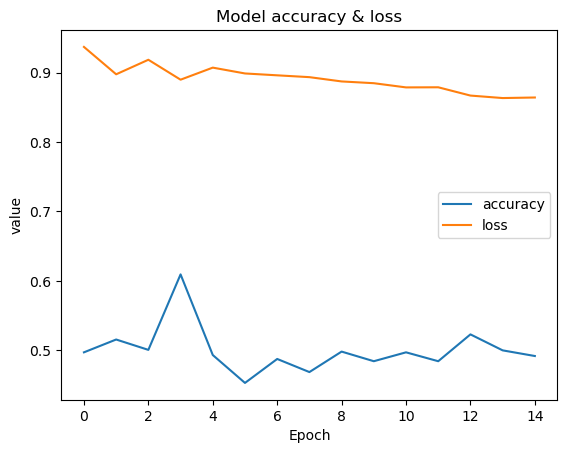

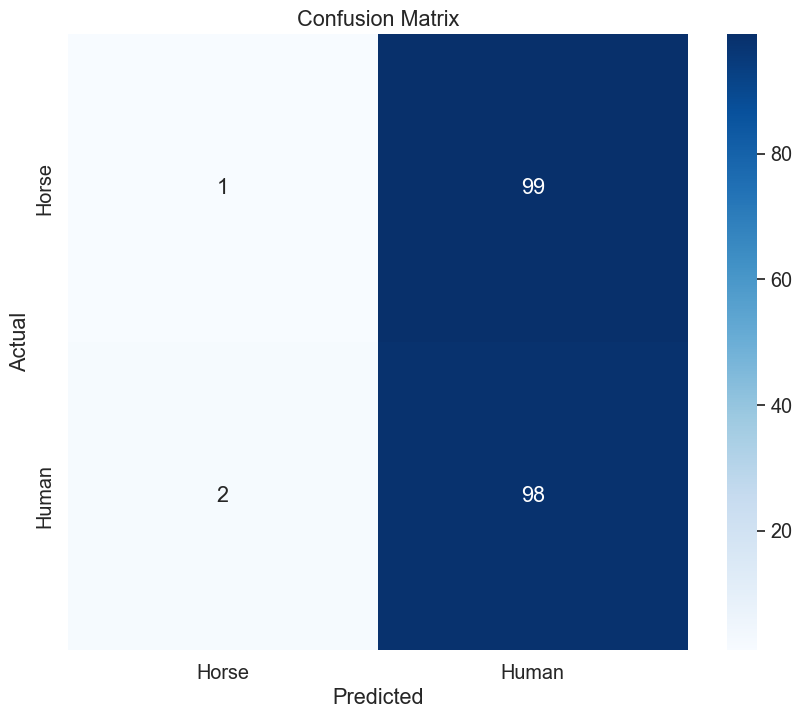

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# 모델 검증
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)
# 이미지 전처리
dlist = './data/test/'
predict_list = os.listdir(dlist)
print(predict_list)

img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (224,224)) for i in img]
img = np.array(img)
img = img.astype('float32') / 255.0

# 분류
cutoff = .5
predictions = model.predict(img)
print(predictions >= cutoff)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(font_scale=1.3)


y_true = np.array([0]*100 + [1]*100)
y_pred = predictions
y_pred_classes = np.round(y_pred).astype(int).flatten()  # 예측값을 0 또는 1로 변환
# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred_classes)
# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Horse", "Human"],
    yticklabels=["Horse", "Human"],
)
plt.xlabel("Predicted" )
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()